In [ ]:
# Import the necessary libraries
import os
import re
import umap
import torch
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Set plot settings
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 50, 'linewidths':0}

In [ ]:
# Load comments
comments = pd.read_csv('Fiona_cleaned_fb_yt.csv')

# Load singBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('zanelim/singbert')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


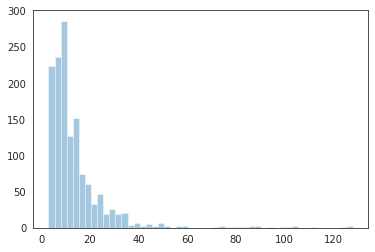

In [ ]:
# Calculate the number of tokens for each comment
num_tokens = [min(len(tokenizer.encode(comment)), 128) for comment in comments.Cleaned_Comments.tolist()]

# Plot the distribution of the number of tokens
sns.distplot(num_tokens, kde=False)

In [ ]:
# Create a dataframe with the num of tokens
num_tokens_df = pd.DataFrame(num_tokens)

# Get summary statistics
print('Min num of tokens: {}'.format(num_tokens_df.min()[0]))
print('Max num of tokens: {}\n'.format(num_tokens_df.max()[0]))

print('Mode num of tokens: {}'.format(num_tokens_df.iloc[:,0].mode()[0]))
print('Mean num of tokens: {}'.format(num_tokens_df.iloc[:,0].mean()))
print('Median num of tokens: {}\n'.format(num_tokens_df.iloc[:,0].median()))

print('75 percentile num of tokens: {}'.format(num_tokens_df.iloc[:,0].quantile(.75)))
print('90 percentile num of tokens: {}'.format(num_tokens_df.iloc[:,0].quantile(.9)))
print('95 percentile num of tokens: {}'.format(num_tokens_df.iloc[:,0].quantile(.95)))
print('99 percentile num of tokens: {}\n'.format(num_tokens_df.iloc[:,0].quantile(.99)))

# Find the number of comments that would be truncated if we set the threshold num of tokens to the model limit of 128
print('Number of truncated comments: {}'.format(num_tokens_df[num_tokens_df.iloc[:,0] > 128].shape[0]))

Min num of tokens: 3
Max num of tokens: 128

Mode num of tokens: 6
Mean num of tokens: 13.723311546840959
Median num of tokens: 10.0

75 percentile num of tokens: 16.0
90 percentile num of tokens: 26.0
95 percentile num of tokens: 34.0
99 percentile num of tokens: 84.48000000000002

Number of truncated comments: 0


In [ ]:
# Tokenize and encode comments
input_seq, input_type, input_mask = tokenizer.batch_encode_plus(
    comments.Cleaned_Comments.tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors='pt').values()

In [ ]:
# Set batch size
batch_size = 64

# Load tensors into TensorDataset
data = TensorDataset(input_seq, input_mask)

# Load TensorDataset into Dataloader
dataloader = DataLoader(data, shuffle=False, batch_size=batch_size, num_workers=8)

In [ ]:
# Load model
encoder = BertModel.from_pretrained("zanelim/singbert").cuda()
encoder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Get the embeddings of each comment
for input, attention in dataloader:
  input, attention = input.cuda(), attention.cuda()

  with torch.no_grad():
    output = encoder(input, attention)

  try:
    avg_embeddings = np.append(avg_embeddings, torch.mean(output.last_hidden_state, dim=1).detach().cpu().numpy(), axis=0)
    cls_embeddings = np.append(cls_embeddings, output.pooler_output.detach().cpu().numpy(), axis=0)

  except:
    avg_embeddings = torch.mean(output.last_hidden_state, dim=1).detach().cpu().numpy()
    cls_embeddings = output.pooler_output.detach().cpu().numpy()

## **Visualisation of embeddings in 2D space**

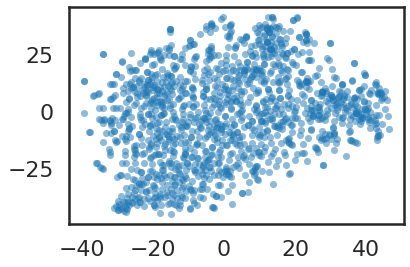

In [ ]:
sns.set_context('poster')

# Visualisation of avg_embeddings
avg_embeddings_projection = TSNE().fit_transform(avg_embeddings)
plt.scatter(*avg_embeddings_projection.T, **plot_kwds)

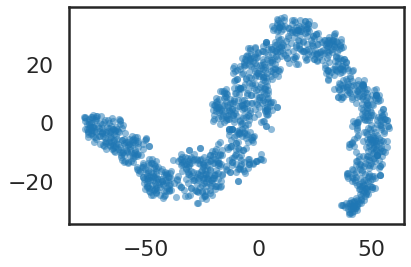

In [ ]:
# Visualisation of cls_embeddings
cls_embeddings_projection = TSNE().fit_transform(cls_embeddings)
plt.scatter(*cls_embeddings_projection.T, **plot_kwds)

## **Clustering with Hdbscan (Without UMAP dimensionality reduction)**

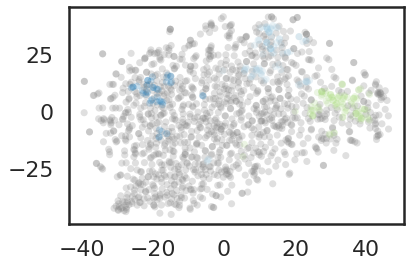

In [ ]:
# Using avg embeddings
avg_clusterer = hdbscan.HDBSCAN(min_cluster_size=15,
                            min_samples=1).fit(avg_embeddings) # Adjust min_cluster_size and min_samples to vary the number of clusters obtained

color_palette = sns.color_palette('Paired', 12)
avg_cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in avg_clusterer.labels_]
avg_cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(avg_cluster_colors, avg_clusterer.probabilities_)]
plt.scatter(*avg_embeddings_projection.T, s=50, linewidth=0, c=avg_cluster_member_colors, alpha=0.25)

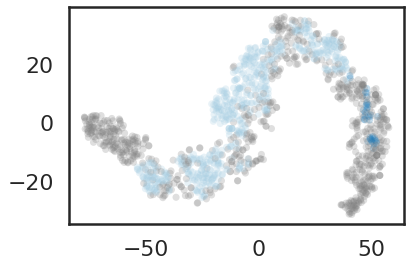

In [ ]:
# Using cls embeddings
cls_clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                            min_samples=1).fit(cls_embeddings) # Adjust min_cluster_size and min_samples to vary the number of clusters obtained

color_palette = sns.color_palette('Paired', 12)
cls_cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cls_clusterer.labels_]
cls_cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cls_cluster_colors, cls_clusterer.probabilities_)]
plt.scatter(*cls_embeddings_projection.T, s=50, linewidth=0, c=cls_cluster_member_colors, alpha=0.25)

## **Clustering with Hdbscan (With UMAP dimensionality reduction)**

In [ ]:
# Let's experiment with some dimensionality reduction of the embeddings before performing the clustering

# Get UMAP embeddings for both the average and cls embeddings
umap_avg_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(avg_embeddings)

umap_cls_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(cls_embeddings)

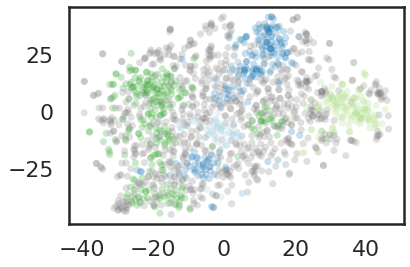

In [ ]:
# Using UMAP avg embeddings
avg_umap_clusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(umap_avg_embeddings) # Adjust min_cluster_size and min_samples to vary the number of clusters obtained

color_palette = sns.color_palette('Paired', 12)
avg_umap_cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in avg_umap_clusterer.labels_]
avg_umap_cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(avg_umap_cluster_colors, avg_umap_clusterer.probabilities_)]
plt.scatter(*avg_embeddings_projection.T, s=50, linewidth=0, c=avg_umap_cluster_colors, alpha=0.25)

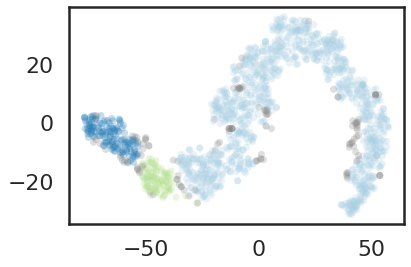

In [ ]:
# Using UMAP cls embeddings
cls_umap_clusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(umap_cls_embeddings) # Adjust min_cluster_size and min_samples to vary the number of clusters obtained

color_palette = sns.color_palette('Paired', 12)
cls_umap_cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cls_umap_clusterer.labels_]
cls_umap_cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cls_umap_cluster_colors, cls_umap_clusterer.probabilities_)]
plt.scatter(*cls_embeddings_projection.T, s=50, linewidth=0, c=cls_umap_cluster_colors, alpha=0.25)

 Empirically, it was observed that the average embeddings produced better semantic clustering results. This is to be expected, since the cls embeddings were not fine-tuned to produce a summarised representation of the entire sequence. 

## **Topic Creation**

In [ ]:
# Append the clustered topics to our comments dataframe; we ignore those using cls embeddings since they do not produce good clustering results
comments['Avg_Topic'] = avg_clusterer.labels_
comments['UMAP_Avg_Topic'] = avg_umap_clusterer.labels_

In [ ]:
# Function to add bigrams
def addBigram(comment):

  # Remove punctuation
  comment = re.sub(r'[^a-z ]', '', comment.lower())

  # Split into tokens
  tokens = comment.split()

  # Construct bigrams
  bigrams = [''.join(tokens[i:i+2]) for i in range(len(tokens)-1)]

  return ' '.join([word for word in (tokens + bigrams)])

In [ ]:
# Add bigrams to the comments
comments['comments_with_bigrams'] = comments.Cleaned_Comments.apply(addBigram)

In [ ]:
# Join the comments from each topic together to form one document per topic
docs_per_topic_avg = comments.groupby(['Avg_Topic'], as_index = False).agg({'comments_with_bigrams': ' '.join})
docs_per_topic_umap = comments.groupby(['UMAP_Avg_Topic'], as_index = False).agg({'comments_with_bigrams': ' '.join})

In [ ]:
# Function to get the top n words from topic
def extract_top_n_words(docs_per_topic, topic_col, n=20, stopwords='english'):

  # Filter out the outliers
  docs_per_topic = docs_per_topic[docs_per_topic[topic_col] != -1]

  # Initialise Tfidf Vectorizer
  vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords)

  # Compute document term matrix
  document_term_matrix = vectorizer.fit_transform(docs_per_topic.comments_with_bigrams).toarray()

  # Get vocabulary
  vocab = vectorizer.get_feature_names()

  # Generate the top n words per topic
  return {doc:[(vocab[word], document_term_matrix[doc][word]) for word in document_term_matrix.argsort(axis=1)[:, -n:][doc][::-1]] for doc in docs_per_topic[topic_col].tolist()}

In [ ]:
# Get top n words per topic for avg embeddings (no UMAP)
top_n_words_avg = extract_top_n_words(docs_per_topic_avg, topic_col='Avg_Topic', n=20, stopwords='english')

# Get top n words per topic for avg embeddings (UMAP)
top_n_words_umap = extract_top_n_words(docs_per_topic_umap, topic_col='UMAP_Avg_Topic', n=20, stopwords='english')

## **Visualise the top 20 words in each topic**

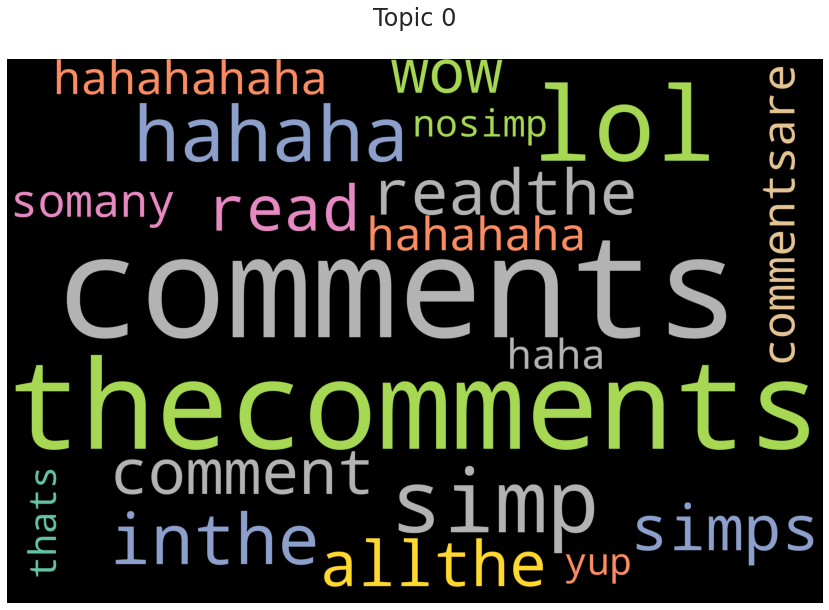

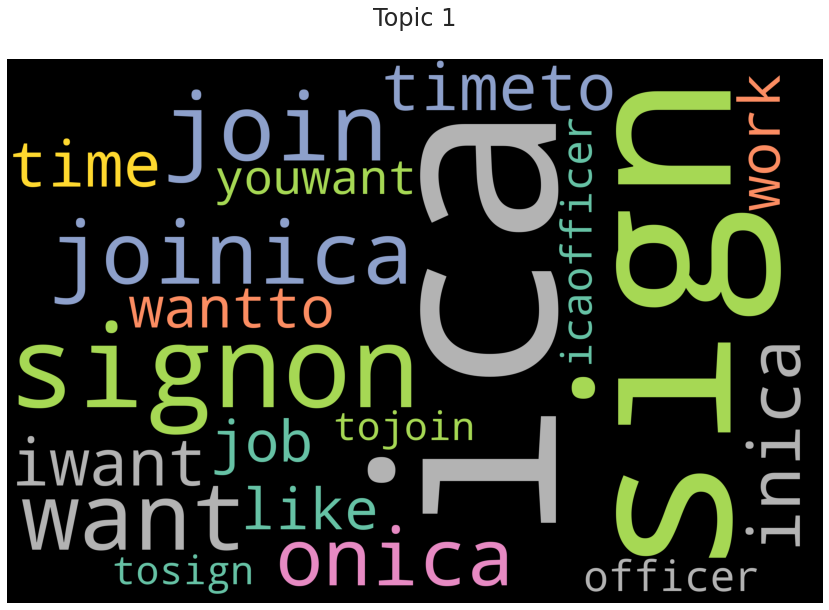

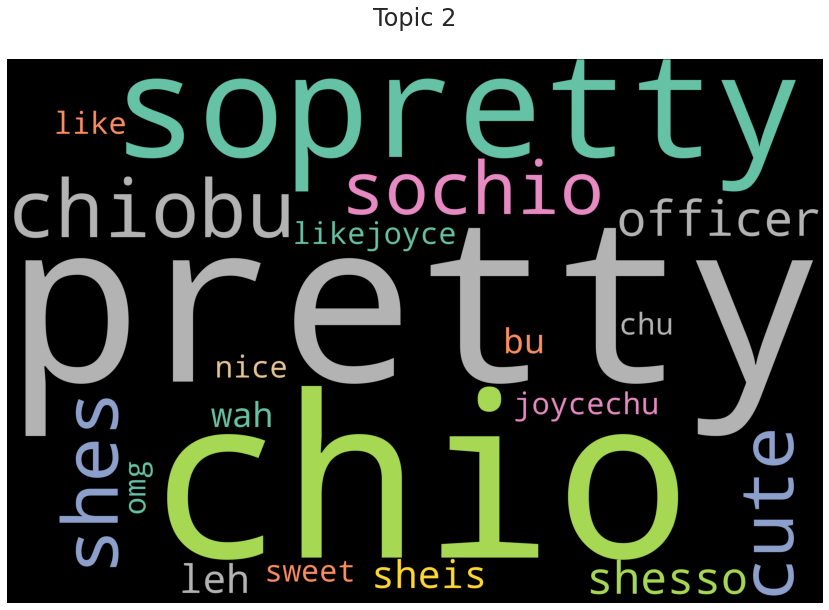

In [ ]:
# Wordcloud for each topic using avg embeddings (no UMAP)
for topicNo, topic in top_n_words_avg.items():

  # Create a dictionary mapping each word to its tfidf score
  word_freq = {word:score for word, score in topic}

  # Create a wordcloud object
  wordcloud = WordCloud(width = 3000, 
                        height = 2000, 
                        random_state=0, 
                        background_color='black', 
                        colormap='Set2', 
                        collocations=False).fit_words(word_freq)

  # Setting this allows you to plot multiple wordclouds in a single cell           
  plt.figure(figsize=(15,10))

  # Set the title of the plot
  plt.title('Topic {}\n'.format(topicNo))

  # Remove the axis
  plt.axis('off')

  # Display the plot
  plt.imshow(wordcloud)

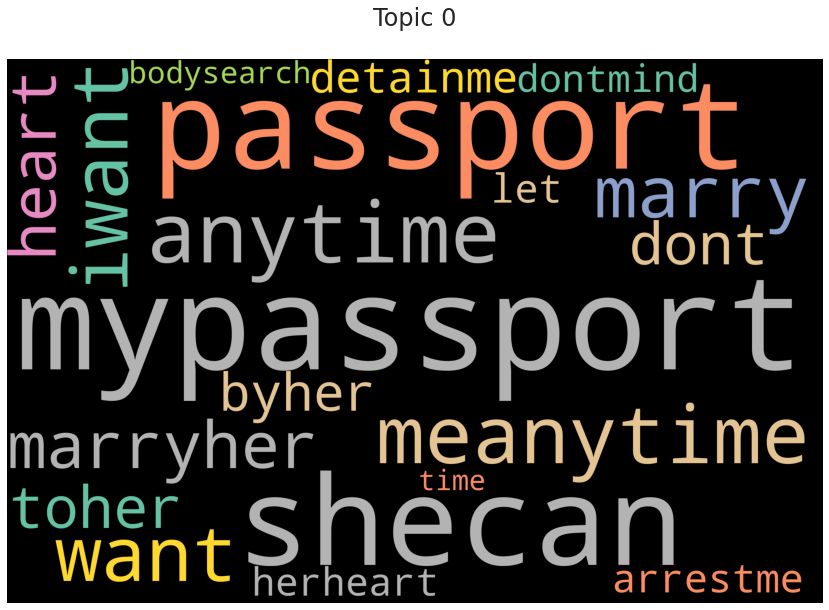

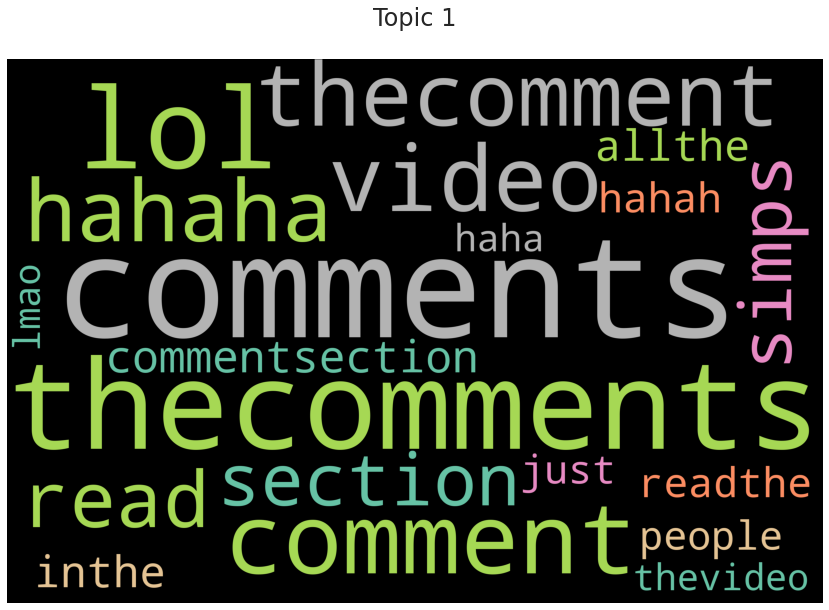

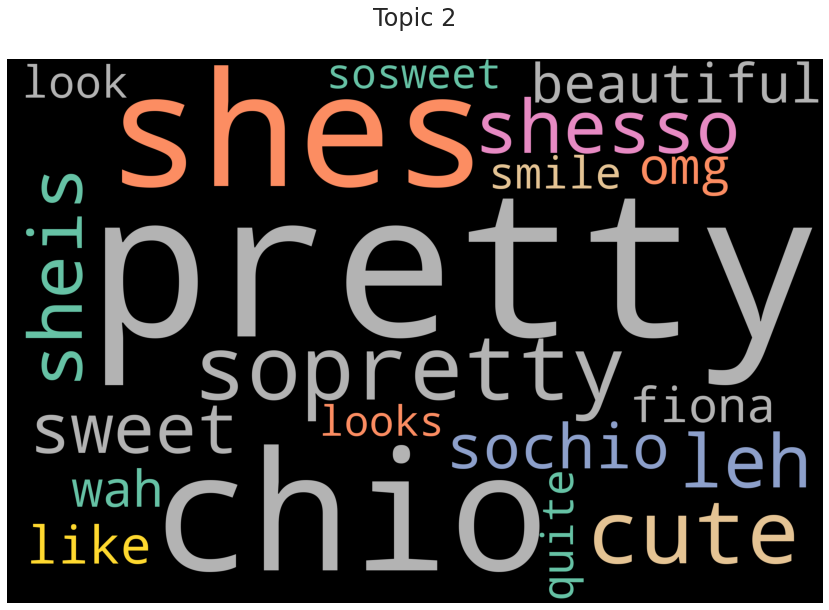

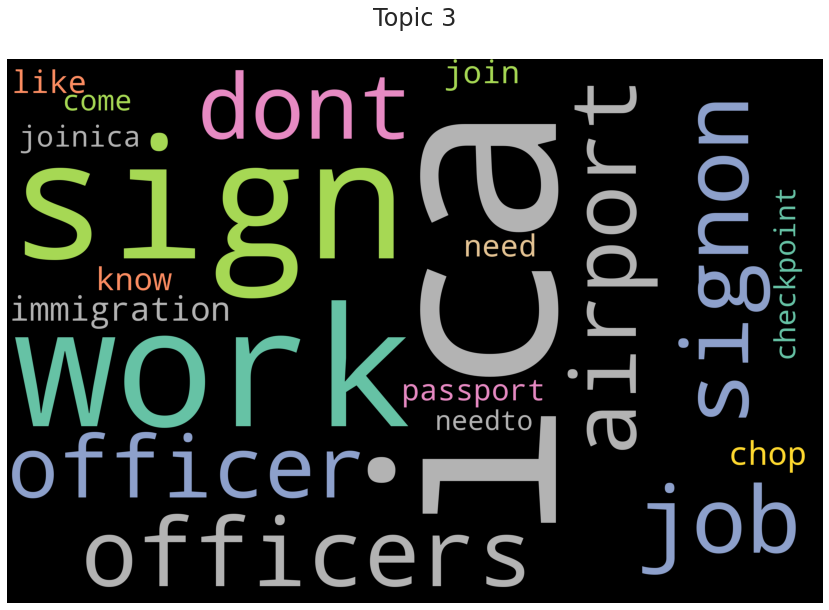

In [ ]:
# Wordcloud for each topic using avg embeddings (UMAP)
for topicNo, topic in top_n_words_umap.items():

  # Create a dictionary mapping each word to its tfidf score
  word_freq = {word:score for word, score in topic}

  # Create a wordcloud object
  wordcloud = WordCloud(width = 3000, 
                        height = 2000, 
                        random_state=0, 
                        background_color='black', 
                        colormap='Set2', 
                        collocations=False).fit_words(word_freq)

  # Setting this allows you to plot multiple wordclouds in a single cell           
  plt.figure(figsize=(15,10))

  # Set the title of the plot
  plt.title('Topic {}\n'.format(topicNo))

  # Remove the axis
  plt.axis('off')

  # Display the plot
  plt.imshow(wordcloud)